**Objective**:
1. Figure out what factors best predict restaurants´ success (at least on Tripadvisor) as measured by ranking

inspired by: https://www.youtube.com/watch?v=bqPARIKHbN8

In [2]:
import pandas as pd 
data = pd.read_csv("restaurants_cleaned.csv")
data.drop(columns=["Unnamed: 0","Reviews"],inplace=True)
data.drop_duplicates(subset ="Name", keep = False, inplace = True)
data.shape

(64377, 7)

In [3]:
data.head()

,Ranking,Rating,Name,City,Cuisine Style,Price Range,Number of Reviews
0,1.0,5.0,Martine of Martine's Table,Amsterdam,"['French', 'Dutch', 'European']",Mid-range,136.0
1,2.0,4.5,De Silveren Spiegel,Amsterdam,"['Dutch', 'European', 'Vegetarian Friendly', '...",Splurge,812.0
2,3.0,4.5,La Rive,Amsterdam,"['Mediterranean', 'French', 'International', '...",Splurge,567.0
3,4.0,5.0,Vinkeles,Amsterdam,"['French', 'European', 'International', 'Conte...",Splurge,564.0
4,5.0,4.5,Librije's Zusje Amsterdam,Amsterdam,"['Dutch', 'European', 'International', 'Vegeta...",Splurge,316.0


In [4]:
#literal.
from ast import literal_eval
data["Cuisine Style"] = data["Cuisine Style"].apply(literal_eval)

In [5]:
data.isnull().sum()

Ranking              0
Rating               0
Name                 0
City                 0
Cuisine Style        0
Price Range          0
Number of Reviews    0
dtype: int64

In [6]:
type(data["Cuisine Style"][0])

list

In [7]:
data["Cuisine Style"] = [" ".join(x) for x in data["Cuisine Style"]]

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = data["Cuisine Style"]
v = TfidfVectorizer()
x = v.fit_transform(df)

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

data2 = pd.concat([data, df1], axis=1)

In [9]:
data2.shape #difference between data and data2?

(73122, 137)

In [10]:
data2.drop(columns=["Name","Cuisine Style"],inplace=True)

In [11]:
categorical_columns = ["City","Price Range"]
dummy_cats = pd.get_dummies(data2[categorical_columns])
drop_data = data2.drop(columns=categorical_columns)
onehot_data2 = drop_data.join(dummy_cats)

In [12]:
onehot_data2.head()

,Ranking,Rating,Number of Reviews,afghani,african,albanian,american,arabic,argentinean,armenian,asian,australian,austrian,azerbaijani,balti,bangladeshi,bar,barbecue,belgian,brazilian,brew,british,burmese,cafe,cajun,cambodian,canadian,caribbean,caucasian,central,chilean,chinese,colombian,contemporary,creole,croatian,cuban,czech,danish,delicatessen,...,vietnamese,welsh,wine,xinjiang,yunnan,zealand,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,Price Range_Budget,Price Range_Mid-range,Price Range_Splurge
0,1.0,5.0,136.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2.0,4.5,812.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3.0,4.5,567.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4.0,5.0,564.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.474252,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5.0,4.5,316.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
onehot_data2.isnull().sum()

Ranking                  8745
Rating                   8745
Number of Reviews        8745
afghani                  8745
african                  8745
                         ... 
City_Warsaw                 0
City_Zurich                 0
Price Range_Budget          0
Price Range_Mid-range       0
Price Range_Splurge         0
Length: 167, dtype: int64

In [14]:
onehot_data2.dropna(inplace=True)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
train,test = train_test_split(onehot_data2,test_size = 0.3)
scaler = StandardScaler()

X_train = scaler.fit_transform(train.drop(columns="Ranking"))
Y_train = train["Ranking"]

#test
X_test = scaler.fit_transform(test.drop(columns="Ranking"))
Y_test = test["Ranking"]

In [16]:
#Forest
from sklearn.tree import DecisionTreeRegressor
regtree = DecisionTreeRegressor(min_samples_split=30,min_samples_leaf=10,random_state=0)
regtree.fit(X_train,Y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=30,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [17]:
from sklearn.metrics import r2_score
predictions = regtree.predict(X_test)
r2_score(Y_test,predictions)

0.9187749036548568

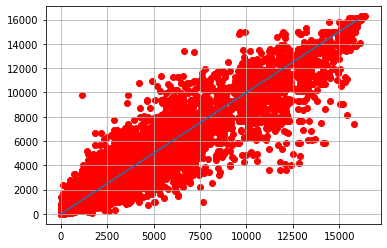

In [18]:
import matplotlib.pyplot as plt

plt.scatter(x=Y_test,y=predictions,color="r")
plt.plot([0,16000],[0,16000])
plt.grid()

In [19]:
from sklearn.feature_selection import RFE

X = onehot_data2.drop(columns="Ranking")
X_scaled = scaler.fit_transform(X)
Y = onehot_data2["Ranking"]

most_important_characteristics = 10
rfe = RFE(regtree, most_important_characteristics,step=100)
rfe = rfe.fit(X,Y)

In [21]:
characteristcs = pd.Series(rfe.ranking_,index=X.columns,).sort_values(ascending=True)
characteristcs[:25]

Rating                   1
City_Berlin              1
City_Barcelona           1
City_London              1
City_Madrid              1
italian                  1
City_Paris               1
spanish                  1
City_Milan               1
Number of Reviews        1
south                    2
polish                   2
City_Athens              2
City_Amsterdam           2
european                 2
fast                     2
portuguese               2
free                     2
french                   2
friendly                 2
german                   2
pizza                    2
Price Range_Mid-range    2
gluten                   2
vegan                    2
dtype: int64